(cap-likelihood)=
# La verosimiglianza 

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import binom
import scipy.stats as st
import math
import arviz as az
from scipy.constants import golden
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
sns.set_theme(
    context="paper",
    style="darkgrid",
    palette="colorblind",
    rc={'figure.figsize': (5.0, 5.0/golden)},
)

La verosimiglianza è una funzione che viene utilizzata nell'inferenza statistica sia nel paradigma bayesiano che in quello frequentista. In entrambi i paradigmi, la sua funzione è quella di quantificare la forza con cui i dati osservati supportano i possibili valori dei parametri sconosciuti di un modello statistico. Questo processo è noto come stima di massima verosimiglianza (Maximum Likelihood Estimation, MLE).

Nella stima di massima verosimiglianza, l'obiettivo è di stimare i parametri di una distribuzione di probabilità dati alcuni dati. La funzione di densità di probabilità di una variabile casuale continua indica approssimativamente la probabilità che una variabile casuale assuma un valore in un piccolo intorno. In questo caso, la funzione di densità di probabilità viene indicata con $P(x | \theta)$ dove $x$ rappresenta il valore della variabile casuale e $\theta$ rappresenta il parametro che descrive la distribuzione di probabilità:

$$
P(x | \theta) = \text{Prob} (\text{valore $x$ estratto da una distribuzione con parametro $\theta$}).
$$

La differenza tra una funzione di densità di probabilità e una funzione di verosimiglianza sta nel fatto che la funzione di densità di probabilità dipende dal valore del parametro $\theta$ mentre i valori della variabile casuale $x_1, \ldots, x_n$ sono considerati noti. La funzione di verosimiglianza, al contrario, dipende dai valori noti della variabile casuale $x_1, \ldots, x_n$ mentre il parametro $\theta$ è considerato sconosciuto. In altre parole, la funzione di verosimiglianza viene utilizzata quando abbiamo raccolto un campione di dati, ma non sappiamo quale distribuzione li ha generati. In questo caso, siamo interessati a fare inferenze sulla distribuzione da cui provengono i dati.

Per la funzione di verosimiglianza, la convenzione è di usare la lettera $L$, mentre per la funzione di densità di probabilità si usa la lettera $P$. Quindi, possiamo scrivere:

$$
\underbrace{L(x_1, \ldots, x_n | \theta)}_{\text{verosimiglianza,} \\ \text{funzione di $\theta$}} = \underbrace{P(x_1, \ldots, x_n | \theta)}_{\text{densità di probabilità,} \\ \text{funzione di $x_1, \ldots, x_n$}}
$$

La funzione di verosimiglianza e la funzione di probabilità (massa o densità) sono formalmente uguali, ma hanno un diverso scopo. Nel primo caso, i parametri $\theta$ sono noti e si utilizza la formula per trovare la (densità di) probabilità dei dati; nel secondo caso, i dati sono noti e, considerando tutti i possibili valori di $\theta$, si cerca di determinare la plausibilità relativa dei dati, alla luce di ciascuno dei possibili valori di $\theta$.

Facciamo un esempio relativo alla distribuzione binomiale.

## Modello binomiale

- La funzione di massa di probabilità descrive la probabilità di ottenere un certo numero di successi (compreso tra 0 e 10) in un dato numero di prove $n$, assumendo una probabilità di successo fissa $\theta$. In altre parole, la funzione di massa di probabilità indica la probabilità di ottenere un certo risultato specifico in un esperimento con le condizioni date.

- D'altra parte, la funzione di verosimiglianza descrive la plausibilità di ogni possibile valore del parametro $\theta$, tenendo conto dei dati osservati $y$. In questo caso, $y$ è noto, mentre $\theta$ rappresenta il valore incognito del parametro da stimare. La funzione di verosimiglianza non è una funzione di densità di probabilità in quanto non è normalizzata per avere area unitaria. In altre parole, la funzione di verosimiglianza fornisce solo informazioni relative sulla plausibilità dei possibili valori del parametro $\theta$ e non fornisce una misura di probabilità assoluta.

Immaginiamo di avere un esperimento ripetuto $n$ volte, dove ogni volta il risultato può essere un successo o un fallimento (ad esempio, lanciare una moneta). Supponiamo di aver ottenuto $y$ successi e $n-y$ fallimenti. La funzione di verosimiglianza, ovvero la plausibilità di osservare questi dati $y$ alla luce di diversi valori di $\theta$, è data dalla formula:

$$
\mathcal{L}(\theta \mid y) = \theta^y (1-\theta)^{n - y}.
$$ (eq-like-binomial-kernel)

La funzione di verosimiglianza riflette la plausibilità che un certo valore di $\theta$ abbia generato i dati osservati $y$. Si noti che al variare dei valori di $y$, la forma della funzione di verosimiglianza cambia, e di conseguenza varia la plausibilità di differenti valori di $\theta$. La funzione di verosimiglianza non dipende da alcuna conoscenza o supposizione a priori sui valori di $\theta$.

Per fare un esempio pratico, consideriamo la ricerca di {cite:t}`zetsche_2019future`. Questi ricercatori hanno trovato che, su 30 pazienti clinicamente depressi, 23 manifestavano delle aspettative distorte negativamente relativamente al loro umore futuro. Se i dati di {cite:t}`zetsche_2019future` vengono riassunti mediante una proporzione (ovvero, 23/30), allora è sensato adottare un modello probabilistico binomiale quale meccanismo generatore dei dati:

$$
y  \sim Binomial(n, \theta),
$$ (eq-binomialmodel)

laddove $\theta$ è la probabiltà che una prova Bernoulliana assuma il valore 1 e $n$ corrisponde al numero di prove Bernoulliane. Questo modello assume che le prove Bernoulliane $y$ che costituiscono il campione siano tra loro indipendenti e che ciascuna abbia la stessa probabilità $\theta \in [0, 1]$ di essere un "successo" (valore 1). In altre parole, il modello generatore dei dati avrà la seguente funzione di massa di probabilità

$$
p(y \mid \theta) = Binomial(y \mid n, \theta).
$$

Nei capitoli precedenti, è stato spiegato come utilizzando il modello binomiale, sia possibile assegnare una probabilità a ciascun valore possibile di $y$ all'interno dell'insieme ${0, 1, \dots, n}$ assumendo che il parametro $\theta$ sia già noto. Tuttavia, ora il problema si inverte, ovvero vogliamo fare inferenza sul valore del parametro $\theta$ dato il nostro campione di dati $y$. In altre parole, sappiamo già quale modello probabilistico è stato utilizzato per generare i dati, ma non conosciamo i valori specifici dei parametri in questione, e vogliamo ottenere informazioni su $\theta$ sulla base dell'osservazione dei dati $y$ disponibili. Per fare ciò, è necessario innanzitutto definire la funzione di verosimiglianza.

Per i dati di {cite:t}`zetsche_2019future`, la funzione di verosimiglianza corrisponde alla funzione binomiale di parametro $\theta \in [0, 1]$ sconosciuto. Avendo osservato $y$ = 23 successi, in $n$ = 30 prove, la funzione di verosimiglianza diventa

$$
\mathcal{L}(\theta \mid y) = \frac{(23 + 7)!}{23!7!} \theta^{23} + (1-\theta)^7.
$$ (eq-likebino23)

Per costruire la funzione di verosimiglianza dobbiamo applicare l'eq. {eq}`eq-likebino23` tante volte, cambiando ogni volta il valore $\theta$, ma tenendo sempre costante il valore dei dati. Nella seguente simulazione considereremo 100 possibili valori $\theta \in [0, 1]$. Iniziamo con il definire i dati.

In [25]:
n = 30
y = 23

Creiamo ora i possibili valori del parametro $\theta$ per i quali calcoleremo la verosimiglianza.

In [26]:
theta = np.linspace(0.0, 1.0, num=100)
print(theta)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

Per esempio, ponendo $\theta = 0.1$ otteniamo il seguente valore dell'ordinata della funzione di verosimiglianza:

$$
\mathcal{L}(\theta \mid y) = \frac{(23 + 7)!}{23!7!} 0.1^{23} + (1-0.1)^7.
$$

In [27]:
st.binom.pmf(y, n, 0.1)

9.7371682902e-18

Ponendo $\theta = 0.2$ otteniamo il seguente valore dell'ordinata della funzione di verosimiglianza:

$$
\mathcal{L}(\theta \mid y) = \frac{(23 + 7)!}{23!7!} 0.2^{23} + (1-0.2)^7.
$$

In [28]:
st.binom.pmf(y, n, 0.2)

3.58141723492221e-11

Se ripetiamo questo processo 100 volte, una volta per ciascuno dei valori $\theta$ che abbiamo elencato sopra, otteniamo 100 coppie di punti $\theta$ e $f(\theta)$. A tale fine, definiamo la seguente funzione.

In [29]:
def like(r, n, theta):
    return math.comb(n, r) * theta**r * (1 - theta) ** (n - r)


La curva che interpola i punti ottenuti è la funzione di verosimiglianza, come indicato dalla figura seguente.

Text(0, 0.5, 'Verosimiglianza')

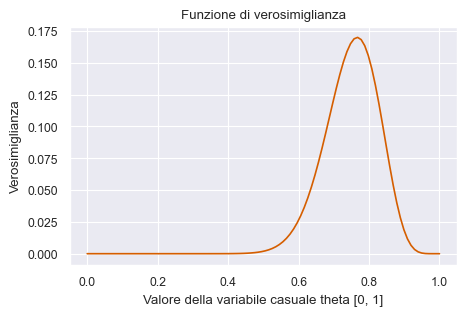

In [30]:
plt.plot(theta, like(r=y, n=n, theta=theta), "r-")
plt.title("Funzione di verosimiglianza")
plt.xlabel("Valore della variabile casuale theta [0, 1]")
plt.ylabel("Verosimiglianza")



### Interpretazione

Come possiamo interpretare la curva di verosimiglianza che abbiamo ottenuto? Per diversi valori di $\theta$, la funzione di verosimiglianza assume valori diversi: per alcuni valori di $\theta$ la funzione assume valori bassi, mentre per altri valori assume valori più alti. I valori di $\theta$ per cui la funzione di verosimiglianza assume valori più alti sono quelli che appaiono più plausibili alla luce dei dati che abbiamo raccolto. In questo caso, il valore 23/30 = 0.767 (che corrisponde alla moda della funzione di verosimiglianza) rappresenta il valore di $\theta$ più plausibile tra tutti quelli che abbiamo preso in considerazione.

Per trovare il valore di $\theta$ che massimizza la funzione di verosimiglianza, dobbiamo individuare l'indice nel vettore che contiene i valori della funzione di verosimiglianza in cui il valore di verosimiglianza è massimo. Possiamo ottenere questo risultato utilizzando la funzione `argmax` di NumPy. Una volta individuato l'indice, possiamo trovare il valore di $\theta$ corrispondente nel vettore `theta`.

In [9]:
l = like(r=y, n=n, theta=theta)
l.argmax()

76

In [10]:
theta[76]

0.7676767676767677

Si noti che, anziché usare la funzione `like()` che (per motivi didattici) abbiamo definito sopra, in una maniera del tutto equivalente è possibile usare la funzione `binom.pmf()`.

Text(0, 0.5, 'Verosimiglianza')

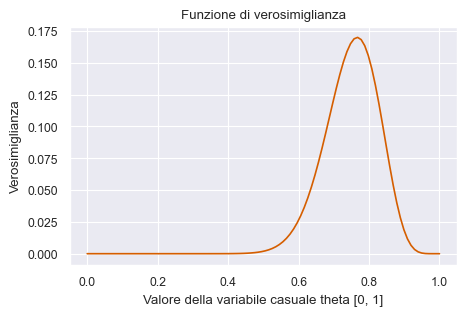

In [11]:
plt.plot(theta, st.binom.pmf(y, n, theta), "r-")
plt.title("Funzione di verosimiglianza")
plt.xlabel("Valore della variabile casuale theta [0, 1]")
plt.ylabel("Verosimiglianza")

### La log-verosimiglianza

Dal punto di vista pratico risulta più conveniente utilizzare, al posto della funzione di verosimiglianza, il suo logaritmo naturale, ovvero la funzione di log-verosimiglianza:

$$
\ell(\theta) = \log \mathcal{L}(\theta).
$$ (eq-loglike-definition)

Poiché il logaritmo è una funzione strettamente crescente (usualmente si considera il logaritmo naturale), allora $\mathcal{L}(\theta)$ e $\ell(\theta)$ assumono il massimo (o i punti di massimo) in corrispondenza degli stessi valori di $\theta$:

$$
\hat{\theta} = argmax_{\theta \in \Theta} \ell(\theta) = argmax_{\theta \in \Theta} \mathcal{L}(\theta).
$$

Per le proprietà del logaritmo, la funzione nucleo di log-verosimiglianza della binomiale è

$$
\begin{aligned}
\ell(\theta \mid y) &= \log \mathcal{L}(\theta \mid y) \notag\\
          &= \log \left(\theta^y (1-\theta)^{n - y} \right) \notag\\
          &= \log \theta^y + \log \left( (1-\theta)^{n - y} \right) \notag\\
          &= y \log \theta + (n - y) \log (1-\theta).\notag
\end{aligned}
$$

È importante sottolineare che non è strettamente necessario lavorare con i logaritmi, ma è altamente raccomandato. La ragione principale è che i valori di verosimiglianza, che rappresentano il prodotto di numeri di probabilità molto piccoli, possono diventare estremamente piccoli, anche dell'ordine di $10^{-34}$. In queste circostanze, è comune che i programmi informatici incontrino problemi di arrotondamento numerico e che si verifichino errori nei calcoli. Utilizzando la trasformazione logaritmica, si evita questo problema, poiché i prodotti diventano somme e i valori diventano più gestibili in termini di scala numerica.

Svolgiamo nuovamente il problema precedente usando la log-verosimiglianza per trovare il massimo della funzione di log-verosimiglianza. Ora utilizziamo la funzione `binom.logpmf()`.

La funzione di log-verosimiglianza è rappresentata nella figura successiva.

Text(0, 0.5, 'Log-verosimiglianza')

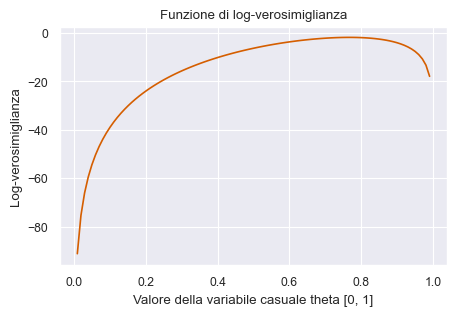

In [12]:
n = 30
r = 23
plt.plot(theta, st.binom.logpmf(y, n, theta), "r-")
plt.title("Funzione di log-verosimiglianza")
plt.xlabel("Valore della variabile casuale theta [0, 1]")
plt.ylabel("Log-verosimiglianza")

Il risultato replica quello trovato in precedenza con la funzione di verosimiglianza.


In [13]:
ll = st.binom.logpmf(y, n, theta)
ll.argmax()

76

In [14]:
theta[76]

0.7676767676767677

## Modello gaussiano

Definiamo ora la funzione di verosimiglianza per la distribuzione gaussiana di parametri $\mu$ e $\sigma$:

$$
\begin{aligned}
L = f(X|\theta) &= f(x_1|\theta) f(x_2|\theta),..., f(x_n|\theta) \\
&= \prod^n_{j=1}f(X| \mu,\sigma^2) \\
&= (2\pi\sigma^2)^{-n/2} \exp{\big(-\frac{1}{2\sigma^2} \sum^n_{j=1}(x_i-\mu)^2\big)}
\end{aligned}
$$(eq-gaussian-sim-like)

Per generare la funzione di verosimiglianza dell'eq. {eq}`eq-gaussian-sim-like`, esaminiamo prima il caso in cui i dati corrispondono ad una singola osservazione $y$.

Supponiamo che la variabile casuale $Y$ rappresenti il quoziente di intelligenza. Poniamo

In [15]:
y = 114

L'eq. {eq}`eq-gaussian-sim-like` dipende dai parametri $\mu$ e $\sigma$ e dai dati $y$. Per semplicità, ipotizziamo $\sigma$ noto e uguale a 15. Nell'esercizio considereremo 1000 valori $\mu$ compresi tra 70 e 160.

In [16]:
mu = np.linspace(70.0, 160.0, num=1000)

Poiché stiamo esaminando 1000 potenziali valori per il parametro $\mu$, per costruire la funzione di verosimiglianza dobbiamo applicare l'equazione {eq}`eq-gaussian-sim-like` 1000 volte - una volta per ciascuno dei valori $\mu$ che stiamo prendendo in considerazione. In questo modo, possiamo valutare la verosimiglianza relativa di osservare i dati che abbiamo raccolto, dati i diversi valori possibili per $\mu$.

In ciascun passo dell'esercizio inseriremo nell'eq. {eq}`eq-gaussian-sim-like`

-   il singolo valore $y$ considerato (che viene mantenuto costante),
-   il valore $\sigma$ assunto noto (anch'esso costante),
-   uno alla volta ciascuno dei valori $\mu$ che abbiamo definito.

Quindi, nelle 1000 applicazioni dell'eq. {eq}`eq-gaussian-sim-like`, il valore $\mu$ è l'unico che varia: $y$ e $\sigma$ sono mantenuti costanti.

In Python, la distribuzione gaussiana può essere implementata attraverso la funzione `norm.pdf()`. Tale funzione richiede tre argomenti: il valore o il vettore di valori $y$ da valutare, la media $\mu$ (o i valori delle medie, se si lavora con più distribuzioni gaussiane) e la deviazione standard $\sigma$ (o i valori delle deviazioni standard, se si lavora con più distribuzioni gaussiane). In altre parole, la funzione `norm.pdf()` consente di calcolare la densità di probabilità gaussiana per ogni valore di $y$ e per ogni coppia di valori di $\mu$ e $\sigma$ specificati.

Applicando la funzione `norm.pdf()` 1000 volte, una volta per ciascuno dei valori $\mu$ che abbiamo definito (e tenendo fissi $y = 114$ e $\sigma = 15$), otteniamo 1000 valori $f(\mu)$.

In [17]:
f_mu = st.norm.pdf(y, loc=mu, scale=15)

La funzione di verosimiglianza è la curva che interpola i punti $\big(\mu, f(\mu)\big)$.

(70.0, 160.0)

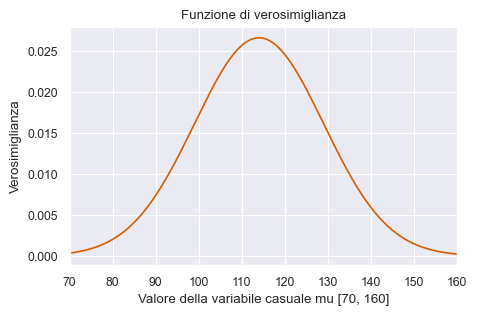

In [18]:
plt.plot(mu, f_mu, "r-")
plt.title("Funzione di verosimiglianza")
plt.xlabel("Valore della variabile casuale mu [70, 160]")
plt.ylabel("Verosimiglianza")
plt.xlim([70, 160])

La funzione di verosimiglianza così trovata ha la forma della distribuzione Gaussiana. Nel caso di una singola osservazione, *ma solo in questo caso*, ha anche un'area unitaria. Per l'esempio presente, la moda della funzione di verosimiglianza è 114.

In [19]:
l = st.norm.pdf(y, loc=mu, scale=15)
mu[l.argmax()]

113.96396396396396

Consideriamo ora il caso più generale di un campione di $n$ osservazioni. Possiamo pensare a questo campione come ad una sequenza di $n$ realizzazioni indipendenti ed identicamente distribuite (abbreviato in i.i.d.) della stessa variabile casuale $Y \sim \mathcal{N}(\mu, \sigma)$, estratte casualmente da una popolazione $\mathcal{N}(\mu, \sigma)$. I parametri della distribuzione normale sconosciuti sono $\theta = {\mu, \sigma}$. 

Se le variabili casuali $y_1, y_2, \dots, y_n$ sono i.i.d., la loro densità congiunta è data da: 

$$
\begin{align}
f(y \mid \theta) &= f(y_1 \mid \theta) \cdot f(y_2 \mid \theta) \cdot \; \dots \; \cdot f(y_n \mid \theta)\notag\\
                 &= \prod_{i=1}^n f(y_i \mid \theta),
\end{align}
$$

laddove $f(\cdot)$ è la densità Gaussiana di parametri $\mu, \sigma$. Tenendo costanti i dati $y$, la funzione di verosimiglianza diventa l'eq. {eq}`eq-gaussian-sim-like`.

<!-- $$
\begin{equation}
\mathcal{L}(\theta \mid y) = \prod_{i=1}^n f(y_i \mid \theta).
\end{equation}
$$ -->

Per chiarire l'eq. {eq}`eq-gaussian-sim-like`, consideriamo un esempio che utilizza come dati i valori BDI-II dei trenta soggetti del campione clinico di {cite:t}`zetsche_2019future`. 

In [13]:
y = [
    26,
    35,
    30,
    25,
    44,
    30,
    33,
    43,
    22,
    43,
    24,
    19,
    39,
    31,
    25,
    28,
    35,
    30,
    26,
    31,
    41,
    36,
    26,
    35,
    33,
    28,
    27,
    34,
    27,
    22,
]

Ci poniamo l'obiettivo di creare la funzione di verosimiglianza per questi dati, supponendo di sapere (in base ai risultati di ricerche precedenti) che i punteggi BDI-II si distribuiscono secondo la legge Normale e supponendo $\sigma$ noto e uguale alla deviazione standard del campione. 

In [14]:
true_sigma = np.std(y)
true_sigma

6.495810615739622

Per la prima osservazione del campione ($y_1 = 26$) abbiamo

$$
f(26 \mid \mu_0, \sigma=6.50) = \frac{1}{{6.50 \sqrt {2\pi}}}\exp\left\{{-\frac{(26 - \mu_0)^2}{2\cdot 6.50^2}}\right\}.
$$

Se consideriamo tutte le osservazioni del campione, la densità congiunta è il prodotto delle densità delle singole osservazioni:


$$f(y \mid \mu, \sigma = 6.50) = \, \prod_{i=1}^n f(y_i \mid \mu, \sigma = 6.50).$$ 

Utilizzando i dati del campione e assumendo $\sigma=6.50$, l'ordinata della funzione di verosimiglianza in corrispondenza di $\mu_0$ è data dal prodotto delle densità di ogni singola osservazione:

$$
\begin{aligned}
\mathcal{L}(\mu_0, \sigma=6.50 \mid y) =& \, \prod_{i=1}^{30} f(y_i \mid \mu_0, \sigma = 6.50) = \notag\\
& \frac{1}{{6.50 \sqrt {2\pi}}}\exp\left\{{-\frac{(26 - \mu_0)^2}{2\cdot 6.50^2}}\right\} \times \notag\\
 & \frac{1}{{6.61 \sqrt {2\pi}}}\exp\left\{{-\frac{(35 - \mu_0)^2}{2\cdot 6.50^2}}\right\} \times  \notag\\
& \vdots \notag\\
 & \frac{1}{{6.61 \sqrt {2\pi}}}\exp\left\{{-\frac{(22 - \mu_0)^2}{2\cdot 6.50^2}}\right\}.
\end{aligned}
$$

Il valore $\mu_0$ rappresenta uno dei possibili valori del parametro $\mu$. Se prendiamo in considerazione 1000 valori possibili per $\mu$, allora dobbiamo ripetere i calcoli precedenti 1000 volte, ovvero una volta per ciascuno dei 1000 valori $\mu$ considerati.

È più conveniente svolgere i calcoli usando il logaritmo della verosimiglianza. In Python definiamo la funzione di log-verosimiglianza, `log_likelihood()`, che prende come argomenti `y`, `mu` e `sigma = 6.50`:

In [17]:
def log_likelihood(y, mu, sigma=true_sigma):
    return np.sum(st.norm.logpdf(y, loc=mu, scale=true_sigma))

Consideriamo, ad esempio, il valore $\mu_0 = \bar{y}$, ovvero


In [18]:
bar_y = np.mean(y)
print(bar_y)

30.933333333333334


L'ordinata della funzione di log-verosimiglianza in corrispondenza di $\mu = 30.93$ è


In [19]:
print(log_likelihood(y, 30.93, sigma=true_sigma))

-98.70288339960591


Troviamo ora i valori della log-verosimiglianza per ciascuno dei 1000 valori $\mu$ nell'intervallo $[\bar{y} - 2 \sigma, \bar{y} + 2 \sigma]$. Iniziamo a definire il vettore `mu`.


In [20]:
mu = np.linspace(np.mean(y) - 2 * np.std(y), np.mean(y) + 2 * np.std(y), num=1000)

Troviamo il valore dell'ordinata della funzione di log-verosimiglianza in corrispondenza di ciascuno dei 1000 valori `mu` che abbiamo definito.

In [21]:
ll = [log_likelihood(y, mu_val, true_sigma) for mu_val in mu]

Nel caso di un solo parametro sconosciuto (nel caso presente, $\mu$) è possibile rappresentare la log-verosimiglianza con una curva che interpola i punti (`mu`, `ll`). Tale funzione descrive la *credibilità relativa* che può essere attribuita ai valori del parametro $\mu$ alla luce dei dati osservati.

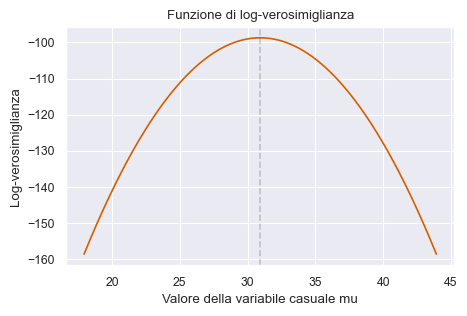

In [22]:
plt.plot(mu, ll, "r-")
plt.title("Funzione di log-verosimiglianza")
plt.xlabel("Valore della variabile casuale mu")
plt.ylabel("Log-verosimiglianza")
plt.axvline(x=np.mean(y), color="k", alpha=0.2, ls="--")

Il valore $\mu$ più credibile corrisponde al massimo della funzione di log-verosimiglinza e viene detto *stima di massima verosimiglianza*.

Il massimo della funzione di log-verosimiglianza, ovvero 30.93 per l'esempio in discussione, è identico alla media dei dati campionari. 

## $\sigma$ ignoto

Per fare un esempio del caso in cui anche il parametro $\sigma$ è ignoto, consideriamo un campione di dati ridotto, ovvero $x_1=-0.5$, $x_2=0$ and $x_3=1.5$. 

In [5]:
X = [-0.5, 0, 1.5]

Per poter creare una visualizzazione bidimensionale, possiamo creare una griglia di potenziali valori dei parametri campionati in modo uniforme su un intervallo, dove $\mu$ è campionato da [-2, 2] e $\sigma$ da [0, 3]. Se campioniamo 100 valori per ogni parametro, otteniamo $n^2$ possibili combinazioni. Per ogni combinazione dei parametri, dobbiamo calcolare la probabilità di ogni valore $\mu$ e $\sigma$ e moltiplicarle insieme seguendo la procedura che abbiamo visto in precedenza.

In [6]:
μ = np.linspace(-2, 2, 100)
σ = np.linspace(0, 3, 100)

l_x = []
for mu in μ:
    for sigma in σ:
        l_x.append(np.prod(tfd.Normal(mu, sigma).prob(X)))
        
l_x = np.asarray(l_x).reshape((100, 100)).T

2023-05-04 06:41:25.435875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ora siamo pronti per rappresentare graficamente la funzione di verosimiglianza. Si noti un'altra volta che essa è una funzione dei valori osservati della v.c., considerati come fissi, ed è espressa in funzione di tutti i possibili valori dei parametri $\mu$ e $\sigma$.

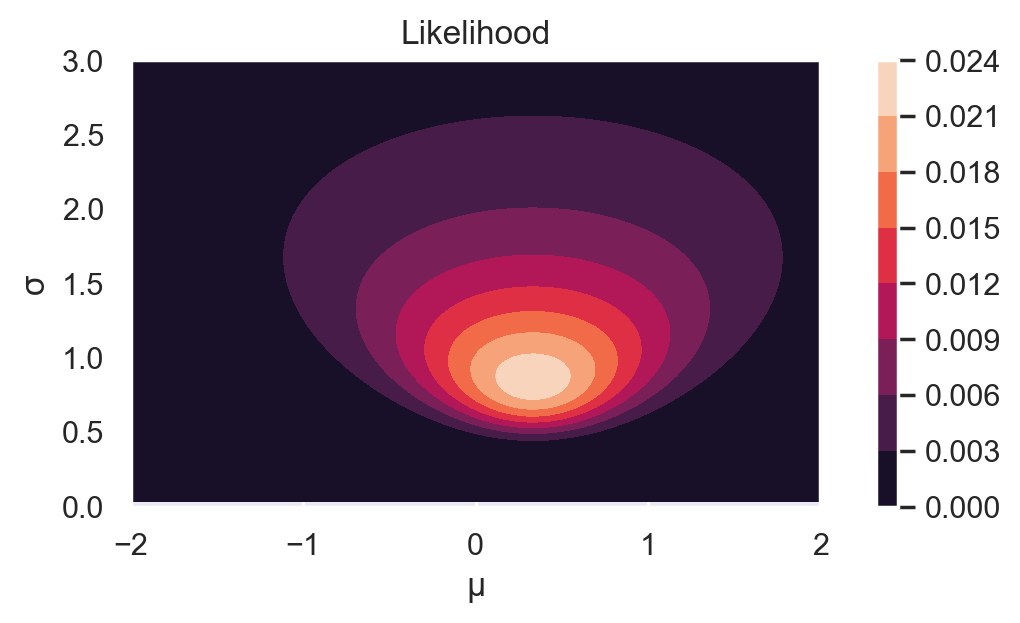

In [7]:
plt.contourf(μ, σ, l_x)
plt.xlabel('μ')
plt.ylabel('σ')
plt.colorbar()
plt.title('Likelihood');

Siamo interessati a massimizzare la probabilità dei nostri dati. Ciò significa che vogliamo trovare il valore massimo della funzione di verosimiglianza, che può essere ottenuto usando il calcolo differenziale. Usiamo la trasformazione logaritmica della funzione di verosimiglianza. 

$$
\begin{aligned}
\log(L(X|\theta)) &= \log\big((2\pi\sigma^2)^{-n/2} \exp{\big(-\frac{1}{2\sigma^2} \sum^n_{j=1}(y_i-\mu)^2\big)\big)} \\
&= -\frac{n}{2}\log(2\pi)-\frac{n}{2}\log(\sigma^2)-\frac{1}{2\sigma^2}\sum_{j=1}^{n}(y_i-\mu)^2
\end{aligned}
$$

La massimizzazione della probabilità dei nostri dati può essere scritta come:

$$
\max_{\mu,\sigma^2}\log(L(X|\theta))
$$

L'espressione derivata sopra può essere differenziata per trovare il massimo. Espandendo i nostri parametri abbiamo $\log(L(X|\mu, \sigma))$. Poiché è una funzione delle due variabili $\mu$ e $\sigma$, utilizziamo le derivate parziali per trovare la stima di massima verosimiglianza. 

Concentriamoci su $\hat \mu$, lo calcoliamo come

$$
\begin{aligned}
& \quad \frac{\partial}{\partial \mu} \log(L(Y|\mu, \sigma)) \\
&= \frac{\partial}{\partial \mu} \big(-\frac{n}{2}\log(2\pi)-\frac{n}{2}\log(\sigma^2)-\frac{1}{2\sigma^2}\sum_{j=1}^{n}(x_i-\mu)^2\big)
\\
&= \sum^n_{j=1} \frac{(x_i - \mu)}{\sigma^2}
\end{aligned}
$$

Impostando l'espressione sopra uguale a zero, otteniamo

$$
\sum^n_{j=1} \frac{(x_i - \mu)}{\sigma^2} = 0.
$$

Quindi

$$
\begin{aligned}
\hat\mu &= \frac{\sum^n_{j=1}x_i}{n} \\
\hat\mu &= \bar x
\end{aligned}
$$

In altri termini, la s.m.v. del parametro $\mu$ è la media del campione (e la s.m.v. del parametro $\sigma$ è la deviazione standard del campione). 

Possiamo ora calcolare i valori massimi della funzione di verosimiglianza per μ e σ dai dati $x_1=-0.5$, $x_2=0$ e $x_3=1.5$ e confrontarli con i valori veri.

In [ ]:
idx_μ_max = np.argmax(l_x, axis=1)[-1]
print(f'μ True Value: {np.array(X).mean()}')
print(f'μ Calculated Value: {μ[idx_μ_max]}')
print(f'σ True Value: {np.array(X).std()}')
print(f'σ Calculated Value: {σ[np.nanargmax(l_x[:,idx_μ_max], axis=0)]}')

## Commenti e considerazioni finali 

La funzione di verosimiglianza rappresenta una funzione dei parametri del modello statistico che genera i dati, dati i dati osservati. In altre parole, quando si osserva un set di dati, la verosimiglianza rappresenta una funzione dei parametri del modello che descrive come i dati sono stati generati. Questa funzione si basa su tre elementi: un modello statistico che genera i dati, un insieme di valori possibili per i parametri del modello e i dati osservati $y$.

Nella statistica frequentista, ci si concentra solo sui dati osservati, senza considerare le informazioni pregresse. L'obiettivo dell'inferenza frequentista è di massimizzare la funzione di verosimiglianza in relazione alle variabili casuali campionarie. Questo è uno dei fondamenti dell'inferenza frequentista. Invece, nella statistica bayesiana, si combina la funzione di verosimiglianza con le distribuzioni a priori dei parametri incogniti $\theta$. In questo modo, i parametri incogniti sono trattati come variabili casuali, consentendo di quantificare il grado di incertezza probabilistica associato al loro valore.

La differenza principale tra l'inferenza bayesiana e quella frequentista è che i frequentisti considerano i parametri incogniti come valori fissi ma sconosciuti, mentre i bayesiani li trattano come variabili casuali con distribuzioni di probabilità a priori. Questo permette ai bayesiani di valutare l'incertezza associata ai parametri del modello statistico e di ottenere stime di probabilità per i valori di questi parametri. Questi concetti saranno ulteriormente discussi nei capitoli successivi.

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w